In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score ,f1_score,roc_curve
import matplotlib.pyplot as plt


In [23]:
%load_ext autoreload
%autoreload 2
from data_prep import df_prep  
from data_prep import  NLP_Vectorizer
from data_prep import parse_line
from model_src import NLP_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
col_names = ['marketplace','customer_id','review_id','product_id','product_parent','product_title','product_category','star_rating','helpful_votes','total_votes','vine','verified_purchase','review_headline','review_body','review_date']
cols = {}
for i in range(len(col_names)):
    print (str(i)+': '+col_names[i])
    cols[col_names[i]] = i

0: marketplace
1: customer_id
2: review_id
3: product_id
4: product_parent
5: product_title
6: product_category
7: star_rating
8: helpful_votes
9: total_votes
10: vine
11: verified_purchase
12: review_headline
13: review_body
14: review_date


In [4]:
np.random.seed(500)
df = pd.read_csv('data/sample_02.csv')
#df = df[df['7']==1]
df = df[df['9']>10]

df = df.sample(frac=.2, random_state=1)
len(df)

3846

In [5]:
Corpus = df_prep(df,.4,.0)

0
1000
2000
3000


In [6]:
list(Corpus['text_final'])[0]

'wonder republican able carry election need read thoughtfully insightful work james webb thoroughly capture spirit ethos ancestry people continue defy politically convention br br bookstore stock sociology section store webb base writing complex sometimes contradictory history people build nation weave together tapestry history oral write concise chronology support assertion downtrodden white capture history essence assimilator great nation build upon melting pot principle creed nationality come together form single united nation secure freedom point truly people acceptance webb show culture show american way assimilation traditional value religion freedom ability go way without fear suppression go great length point contradiction culture actually strengthen standing church rather bow god pious puritanical principle willing look way little drinking resentful big try rule life people willing back national leader earn respect br br essence webb paint illuminating thesis show attribute le

In [7]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus[['text','text_final','help_score','help_votes','stars']],Corpus['label'],test_size=0.3)



Train_X_Vector, Test_X_Vector, Train_Y, Test_Y = vectorize_df(Train_X['text_final'], Test_X['text_final'], Train_Y, Test_Y,'TF_IDF')





In [8]:
TF_IDF = NLP_Vectorizer('TF_IDF',{'max_features':2000,'ngram_range':(1,3)})
orig_Test_Y = Test_Y
orig_Train_Y = Train_Y
Test_Y = TF_IDF.encode_Y(Test_Y)
Train_Y = TF_IDF.encode_Y(Train_Y)

In [9]:
TF_IDF.fit(Train_X['text_final'])
Train_X_Vector = TF_IDF.transform(Train_X['text_final'])
Test_X_Vector = TF_IDF.transform(Test_X['text_final'])

In [25]:
list(Train_X['text_final'])[0] == parse_line(list(Train_X['text'])[0])

True

In [24]:
parse_line(list(Train_X['text'])[0])

'excellent railroad book cover much usual book griffin typical locomotive picture also text operation line along picture equipment must sal fan like colorful se railroad'

In [12]:
NVB = NLP_model('XGBoost')

In [13]:
NVB.fit(Train_X_Vector,Train_Y)

In [14]:
NVB_predict = NVB.predict(Test_X_Vector)

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/nathan/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/nathan/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/nathan/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/nathan/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/nathan/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/nathan/nltk_data...
[nltk_data]    |   Package movie_reviews is already

In [15]:
accuracy_score(NVB_predict,Test_Y)

0.8782608695652174

In [16]:
NVB_predict

array([1, 1, 1, ..., 1, 1, 1])

In [17]:
sum(NVB_predict)/len(NVB_predict)

0.9643478260869566

In [18]:
sum(Test_Y)/len(Test_Y)

0.8930434782608696

In [19]:
Test_X['preds'] = NVB_predict
Test_X['actual'] = Test_Y

In [20]:
Test_X['correct'] = Test_X['preds'] == Test_X['actual']

In [21]:
Test_X['actual']

55454    1
16126    1
24517    1
47010    1
62439    1
        ..
19401    0
22187    1
34965    0
22952    1
46168    1
Name: actual, Length: 1150, dtype: int64

/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


(array([0.03960396, 0.00990099, 0.04950495, 0.01980198, 0.42574257,
        0.73267327, 0.76237624, 1.17821782, 2.04950495, 4.73267327]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

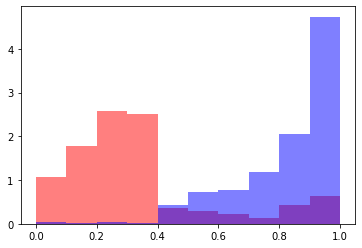

In [22]:
plt.hist(Test_X[Test_X['correct']==False]['help_score'],bins=10,normed=True,color='red',alpha=.5)
plt.hist(Test_X[Test_X['correct']==True]['help_score'],bins=10,normed=True,color='blue',alpha=.5)